## Binding Hypercomplex Numbers

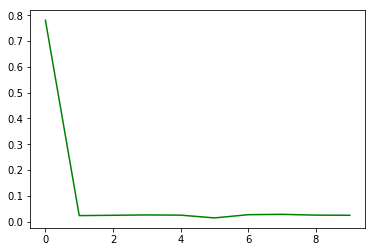

Value Maximum Similarity: 0


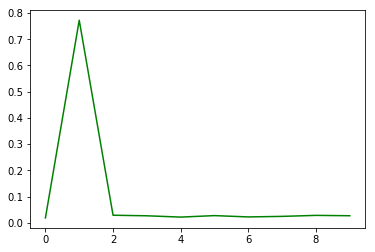

Value Maximum Similarity: 1


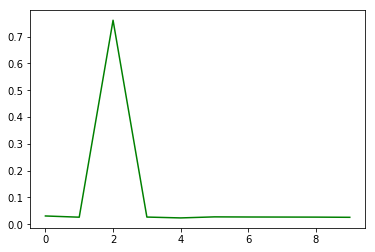

Value Maximum Similarity: 2


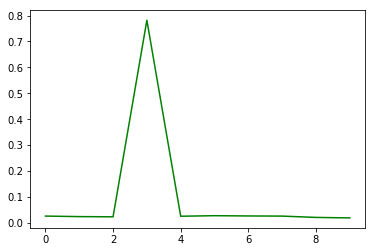

Value Maximum Similarity: 3


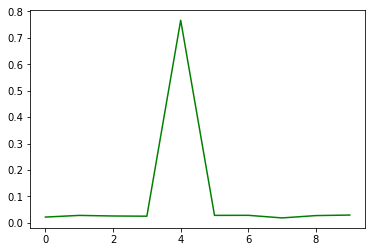

Value Maximum Similarity: 4


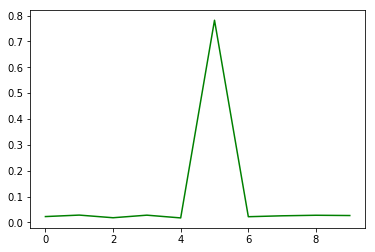

Value Maximum Similarity: 5


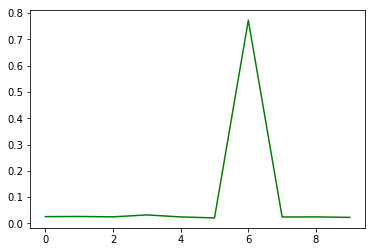

Value Maximum Similarity: 6


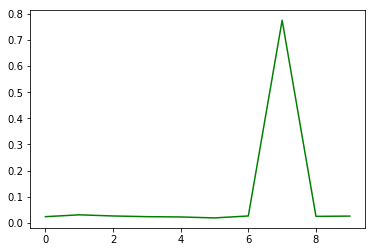

Value Maximum Similarity: 7


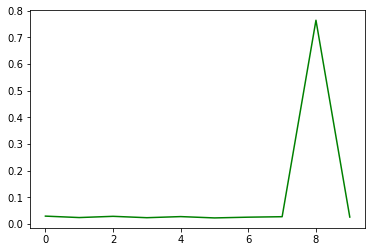

Value Maximum Similarity: 8


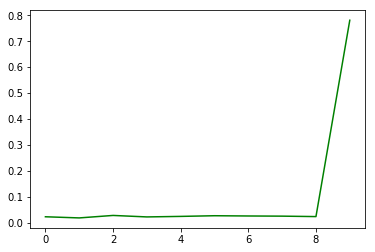

Value Maximum Similarity: 9


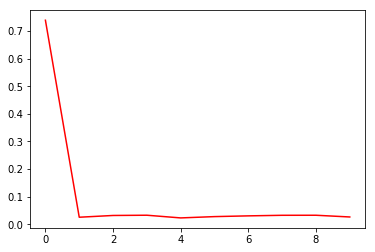

Key Maximum Similarity: 0


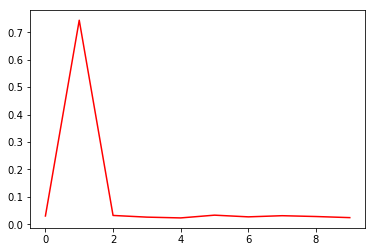

Key Maximum Similarity: 1


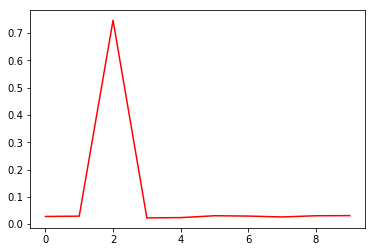

Key Maximum Similarity: 2


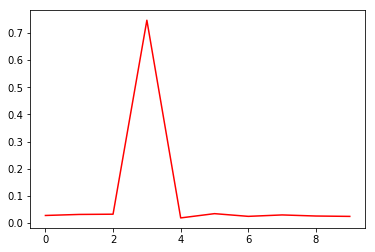

Key Maximum Similarity: 3


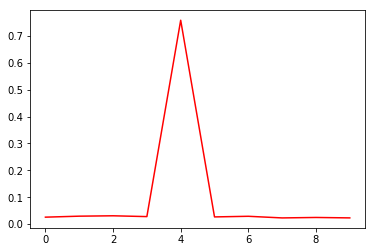

Key Maximum Similarity: 4


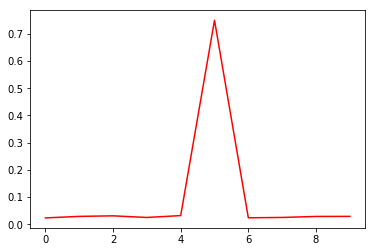

Key Maximum Similarity: 5


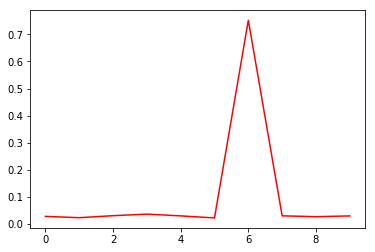

Key Maximum Similarity: 6


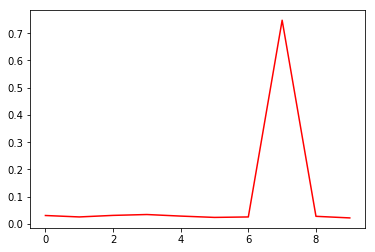

Key Maximum Similarity: 7


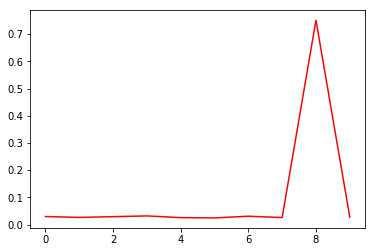

Key Maximum Similarity: 8


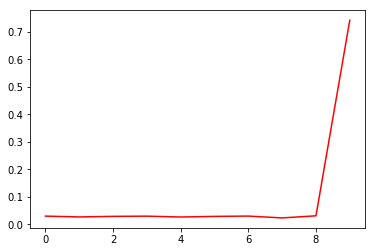

Key Maximum Similarity: 9


In [2]:
import numpy as np
import matplotlib.pyplot as plt


N = 10000
S = 10
M = 2**(5)


keys = []
for _ in range(S):
    rows = np.random.normal(0.0, 1.0, (N, M))
    row_magnitudes = np.sum(rows * rows, axis=1, keepdims=True)**(1/2)
    k = rows / row_magnitudes
    keys += [k]

    
values = []
for _ in range(S):
    rows = np.random.normal(0.0, 1.0, (N, M))
    row_magnitudes = np.sum(rows * rows, axis=1, keepdims=True)**(1/2)
    v = rows / row_magnitudes
    values += [v]


def hypercomplex_conjugate(a, m=M):
    if m == 1:
        return a
    else:
        return np.concatenate([
            hypercomplex_conjugate(a[..., :(m - 1)], m=(m - 1)),
            (-1 * a[..., (m - 1):m])
        ], axis=(len(a.shape) - 1))

    
def hypercomplex_multiply(a, b, m=M):
    if m == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r,
                    m=(m//2)) -
                 hypercomplex_multiply(
                     hypercomplex_conjugate(s, m=(m//2)),
                     q,
                     m=(m//2))),
                (hypercomplex_multiply(
                    s,
                    p,
                    m=(m//2)) +
                 hypercomplex_multiply(
                     q,
                     hypercomplex_conjugate(r, m=(m//2)),
                     m=(m//2))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(m//2)],
            a[..., (m//2):],
            b[..., :(m//2)],
            b[..., (m//2):])

    
def hypercomplex_dot(a, b, m=M):
    return np.sum(
        hypercomplex_multiply(
            hypercomplex_conjugate(a, m=m), 
            b, m=m), axis=0, keepdims=True)


def hypercomplex_magnitude(a, m=M):
    return np.sqrt(np.sum(a * a, axis=1, keepdims=True))
    
    
superposition = np.zeros((N, M))
for k, v in zip(keys, values):
    superposition += hypercomplex_multiply(k, v)
    

for k in keys:
    recovered = hypercomplex_multiply(hypercomplex_conjugate(k), superposition)
    
    probabilities = np.zeros((0, 1))
    for v in values:
        similarity = hypercomplex_magnitude(hypercomplex_dot(recovered, v))
        probabilities = np.vstack([probabilities, similarity])
    probabilities /= np.sum(probabilities)
    
    plt.plot(probabilities, "g")
    plt.show()
    selected = np.argmax(probabilities)
    print("Value Maximum Similarity:", selected)
    
    
for v in values:
    recovered = hypercomplex_multiply(hypercomplex_conjugate(superposition), v)
    
    probabilities = np.zeros((0, 1))
    for k in keys:
        similarity = hypercomplex_magnitude(hypercomplex_dot(k, recovered))
        probabilities = np.vstack([probabilities, similarity])
    probabilities /= np.sum(probabilities)
    
    plt.plot(probabilities, "r")
    plt.show()
    selected = np.argmax(probabilities)
    print("Key Maximum Similarity:", selected)

## The Hypercomplex Fourier Transform

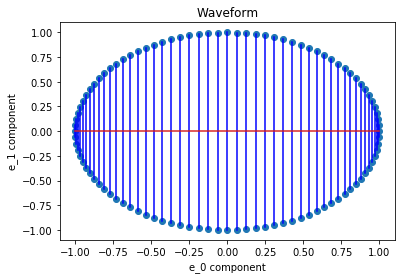

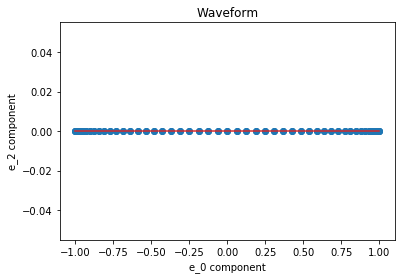

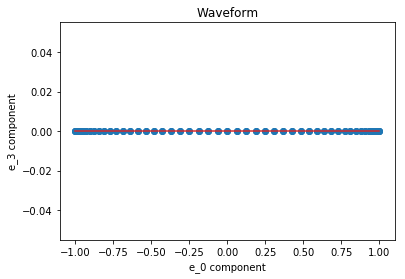

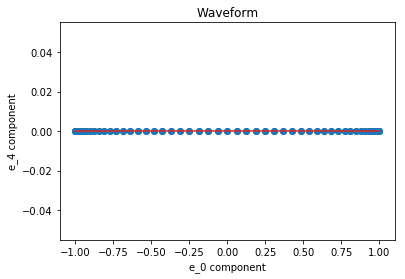

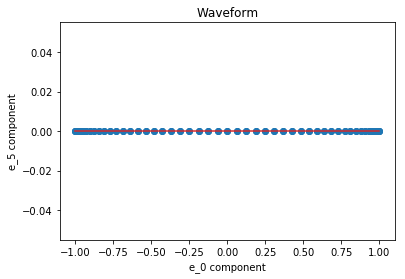

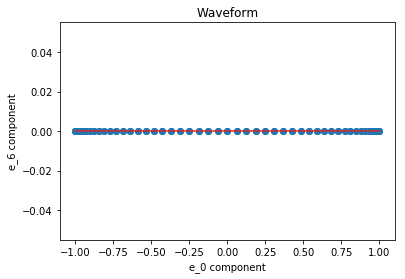

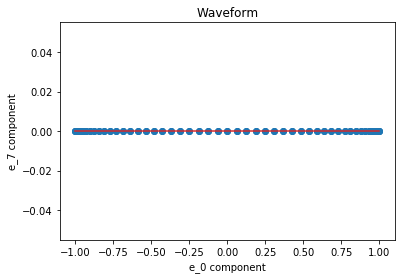

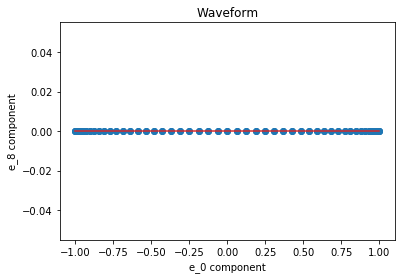

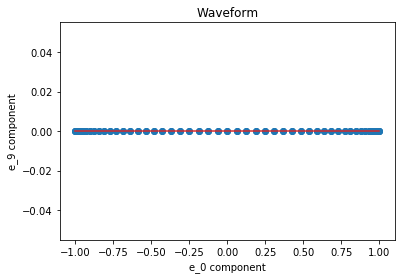

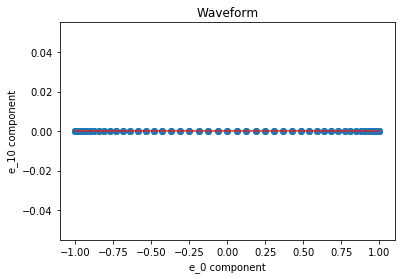

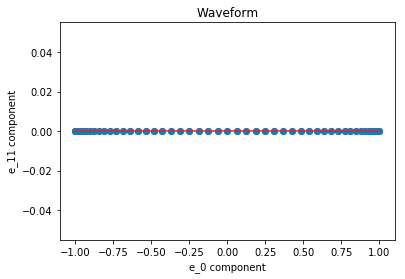

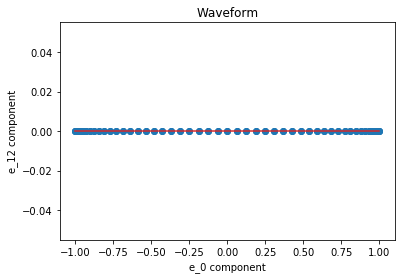

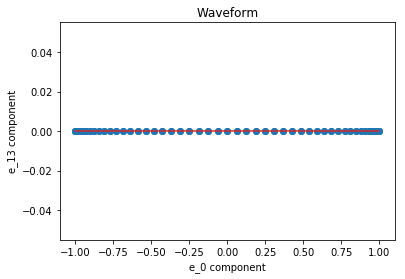

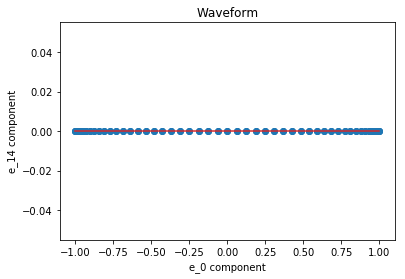

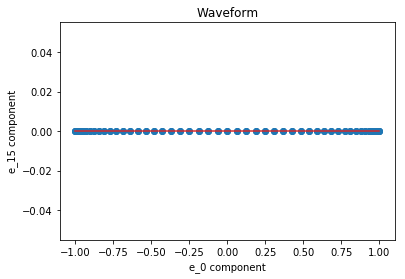

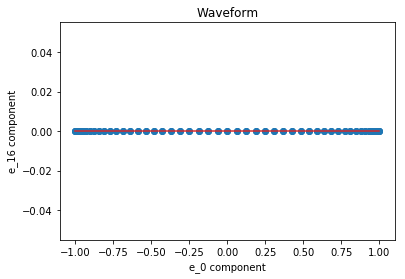

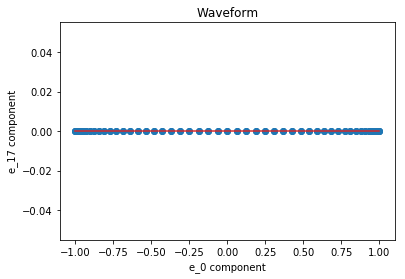

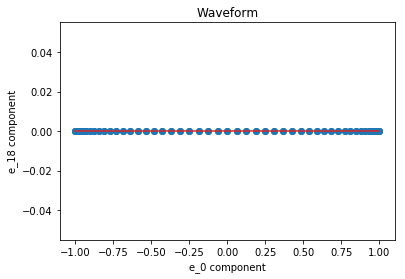

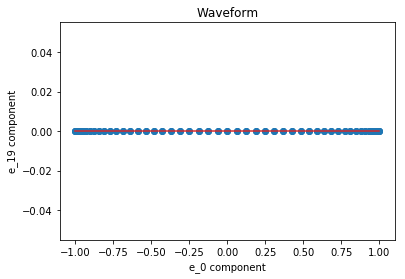

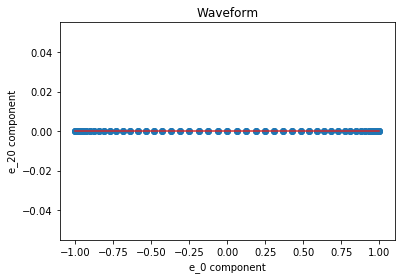

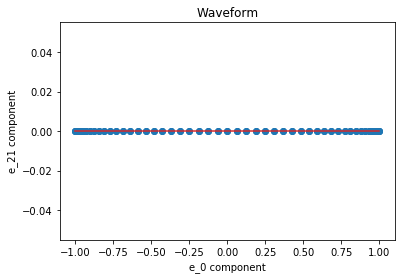

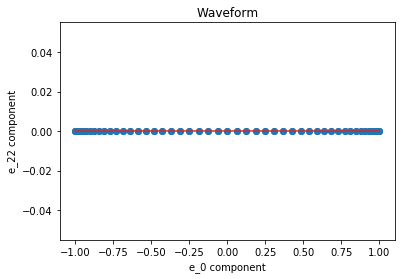

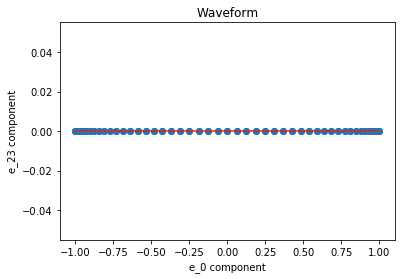

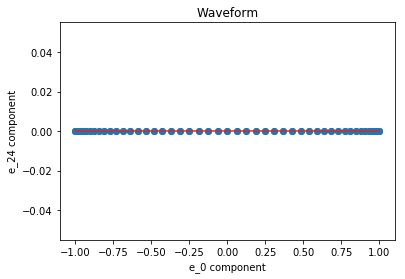

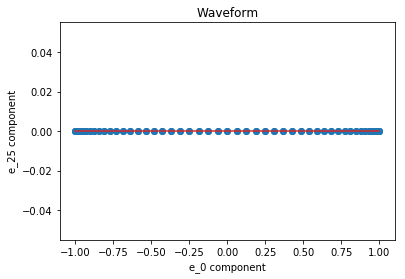

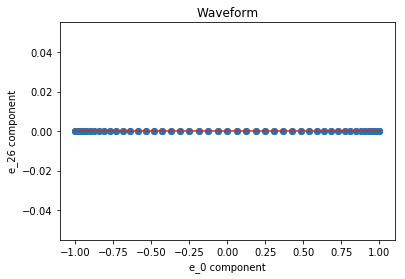

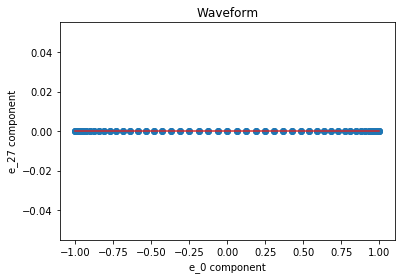

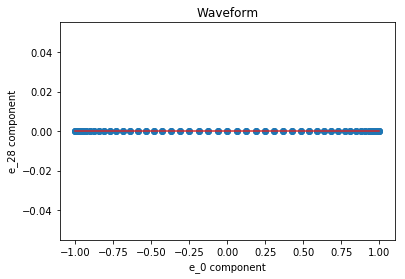

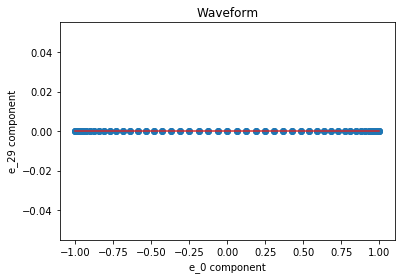

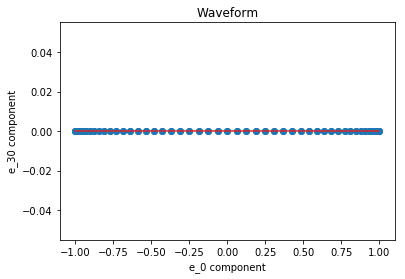

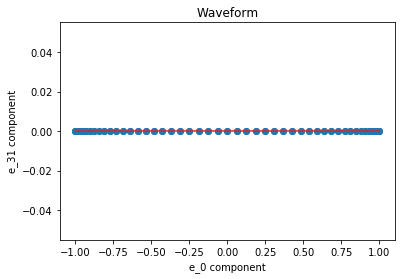

In [1]:
import numpy as np
import matplotlib.pyplot as plt


N = 100
M = 32

def hypercomplex_conjugate(a, m=M):
    if m == 1:
        return a[...]
    else:
        return np.concatenate([
            hypercomplex_conjugate(a[..., :(m - 1)], m=(m - 1)),
            (-1 * a[..., (m - 1):m])
        ], axis=(len(a.shape) - 1))

    
def hypercomplex_multiply(a, b, m=M):
    if m == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r,
                    m=(m//2)) -
                 hypercomplex_multiply(
                     hypercomplex_conjugate(s, m=(m//2)),
                     q,
                     m=(m//2))),
                (hypercomplex_multiply(
                    s,
                    p,
                    m=(m//2)) +
                 hypercomplex_multiply(
                     q,
                     hypercomplex_conjugate(r, m=(m//2)),
                     m=(m//2))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(m//2)],
            a[..., (m//2):],
            b[..., :(m//2)],
            b[..., (m//2):])
    
    
def hypercomplex_dft(a, n=N, m=M, v=np.ones(M)):
    def hypercomplex_euler():
        coefficients = np.dot(
            np.arange(n).reshape((n, 1)),
            np.arange(n).reshape((1, n))).reshape((n, n, 1))
        amplitude = np.exp(v[0] * 2 * np.pi * coefficients / n)
        magnitude = np.sqrt(np.sum(v[1:] * v[1:]))
        return np.concatenate([
            (amplitude * np.cos(2 * np.pi * coefficients * magnitude / n)),
            (np.tile(
                amplitude * np.sin(2 * np.pi * coefficients * magnitude / n) / magnitude, 
                (1, 1, (m - 1))) * v[1:].reshape((1, 1, (m - 1))))], axis=2)
    return np.sum(
        hypercomplex_multiply(
            1 / hypercomplex_euler(), 
            np.tile(
                a.reshape((n, 1, m)),
                (1, n, 1)),
            m=m), axis=0) / n


def hypercomplex_idft(a, n=N, m=M, v=np.ones(M)):
    def hypercomplex_euler():
        coefficients = np.dot(
            np.arange(n).reshape((n, 1)),
            np.arange(n).reshape((1, n))).reshape((n, n, 1))
        amplitude = np.exp(v[0] * 2 * np.pi * coefficients / n)
        magnitude = np.sqrt(np.sum(v[1:] * v[1:]))
        return np.concatenate([
            (amplitude * np.cos(2 * np.pi * coefficients * magnitude / n)),
            (np.tile(
                amplitude * np.sin(2 * np.pi * coefficients * magnitude / n) / magnitude, 
                (1, 1, (m - 1))) * v[1:].reshape((1, 1, (m - 1))))], axis=2)
    return np.sum(
        hypercomplex_multiply(
            hypercomplex_euler(),
            np.tile(
                a.reshape((n, 1, m)),
                (1, n, 1)),
            m=m), axis=0)


test_kernel = np.zeros(M)
test_kernel[1] = 1


frequency = np.zeros((N, M))
frequency[1, 0] = 1
waveform = hypercomplex_idft(frequency, v=test_kernel)


for i in range(1, M):
    plt.stem(waveform[:, 0], waveform[:, i], "b")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("Waveform")
    plt.show()
    

## Gradient Descent with Hypercomplex Numbers

Final Loss: 6.61005984401


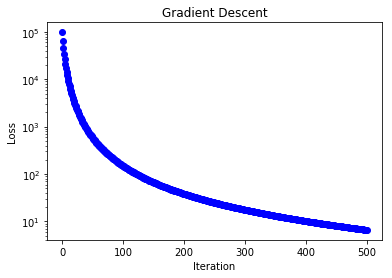

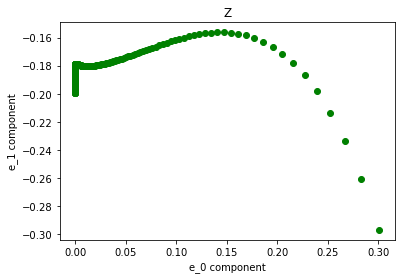

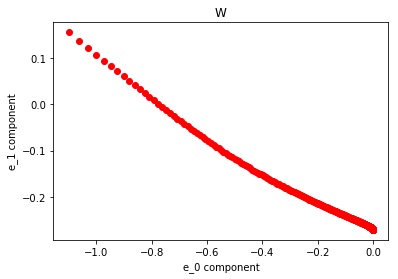

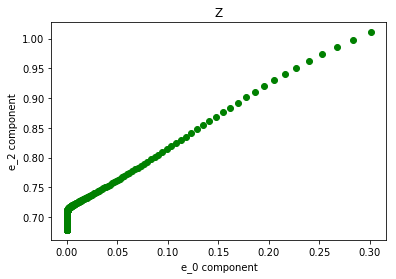

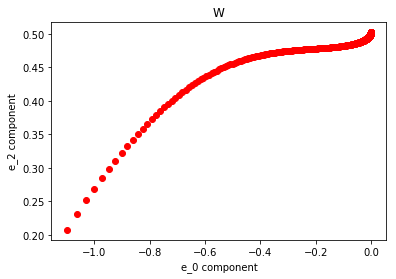

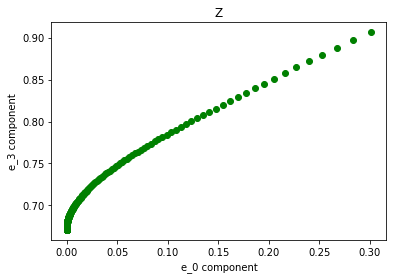

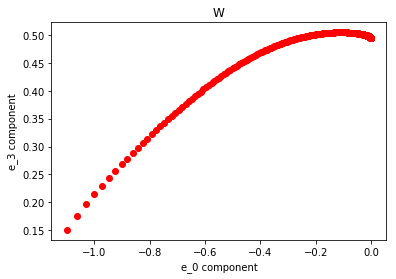

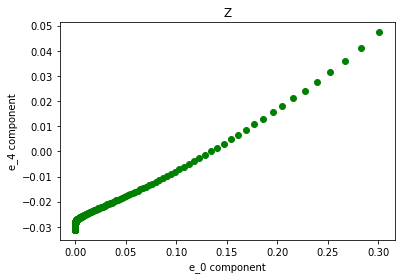

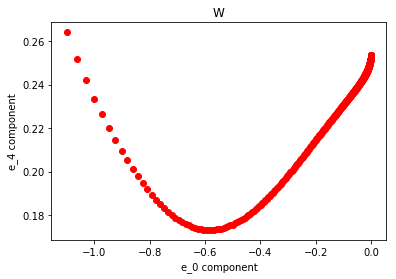

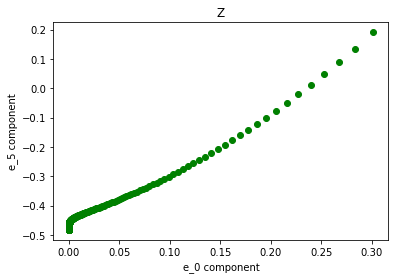

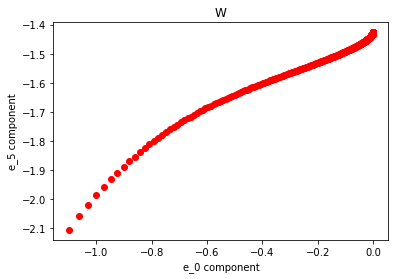

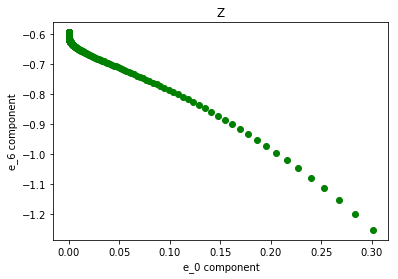

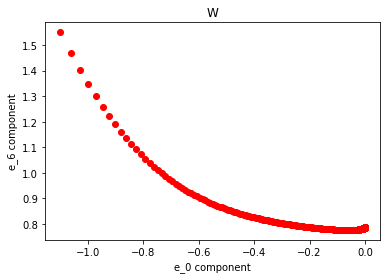

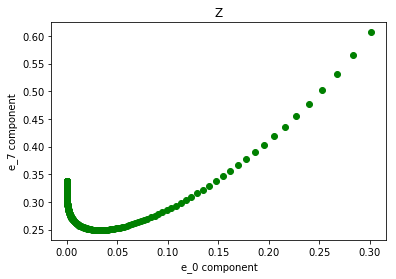

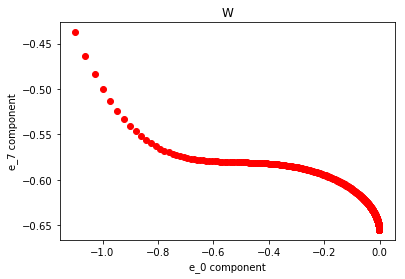

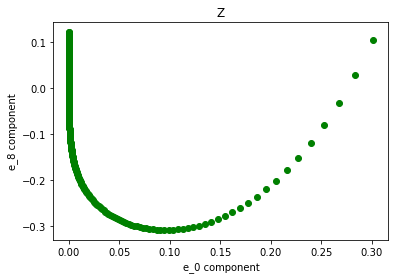

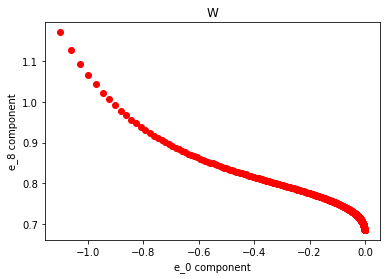

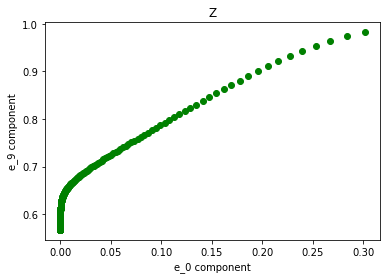

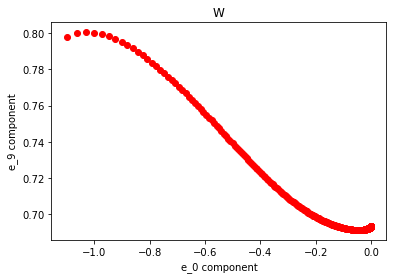

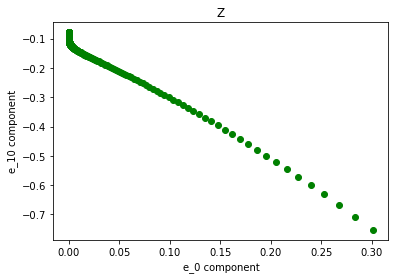

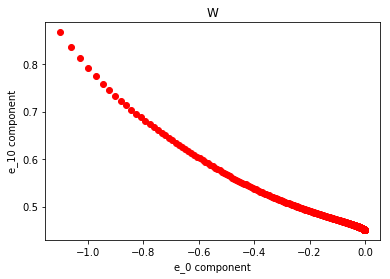

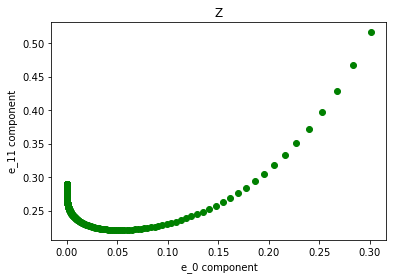

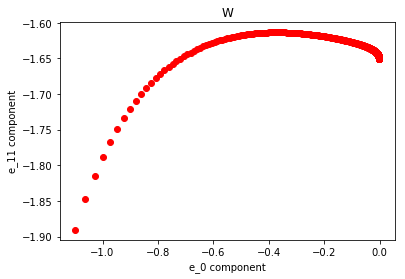

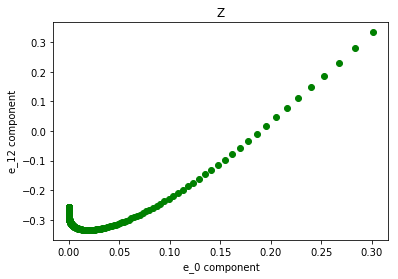

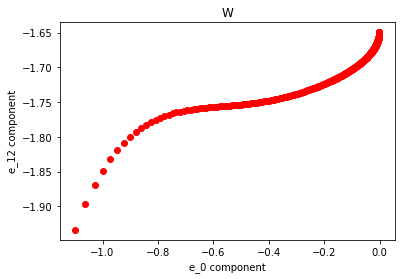

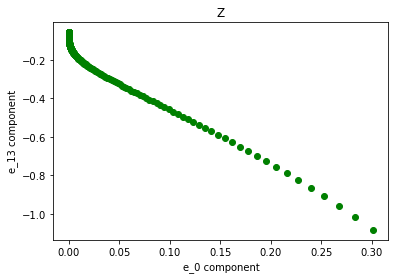

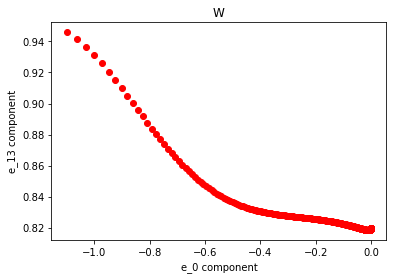

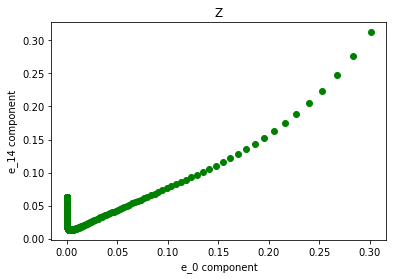

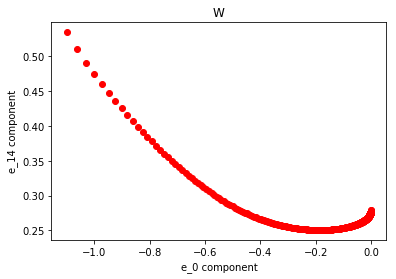

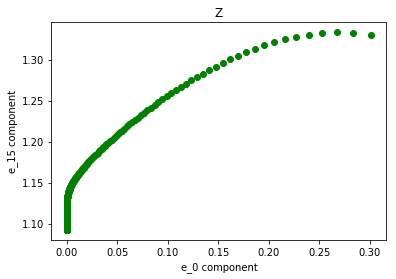

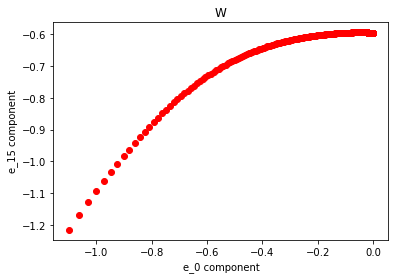

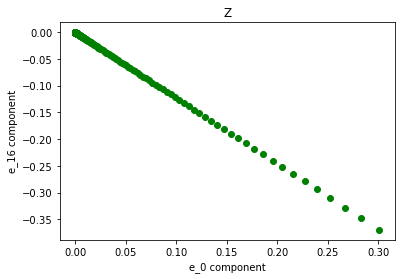

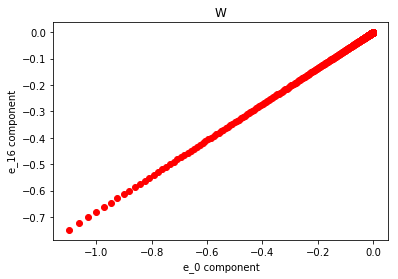

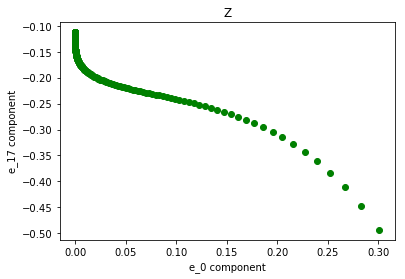

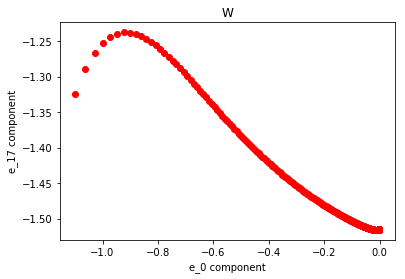

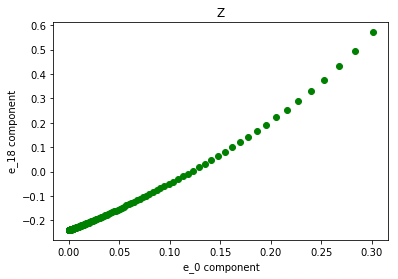

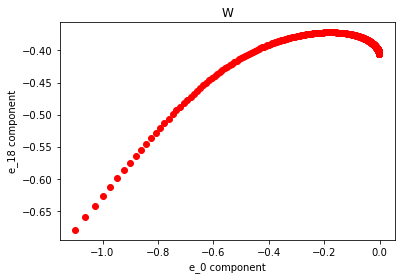

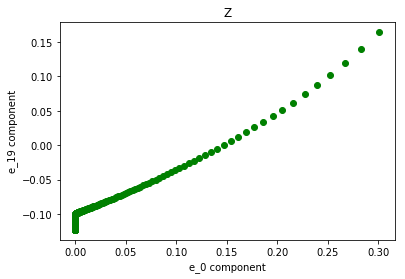

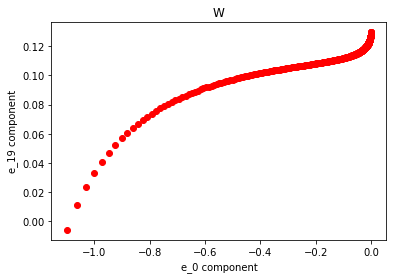

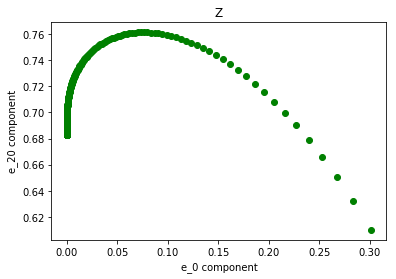

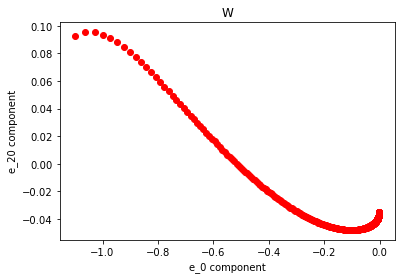

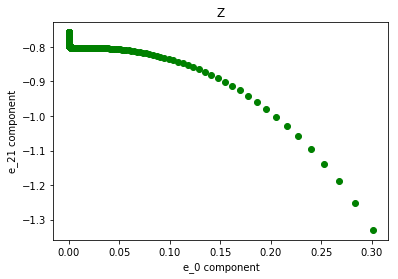

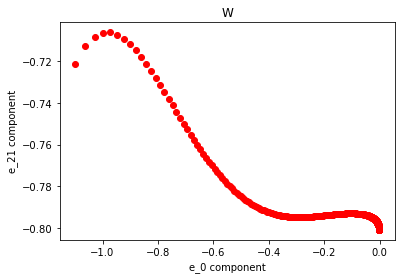

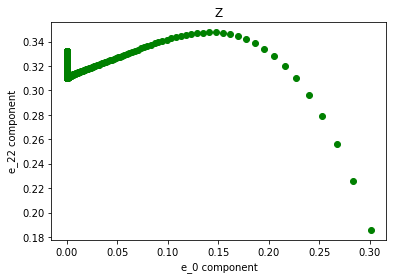

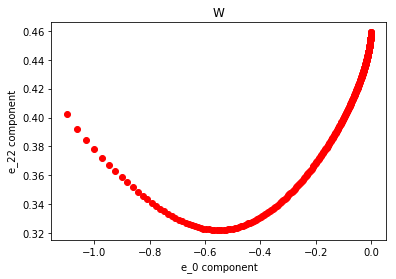

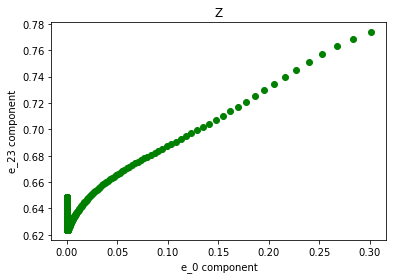

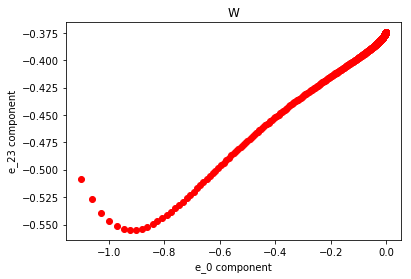

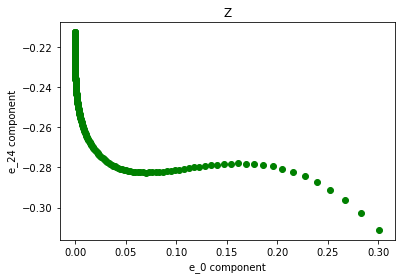

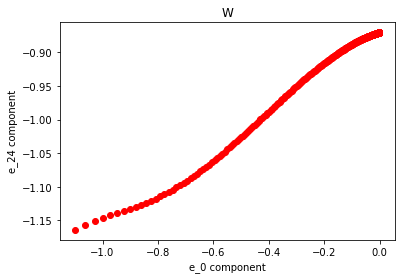

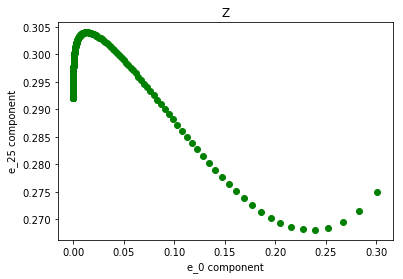

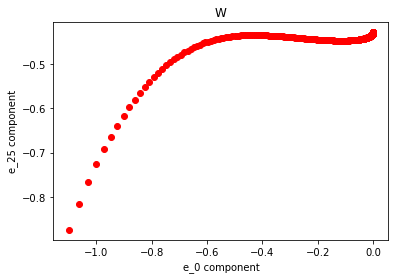

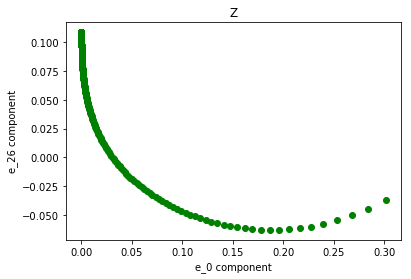

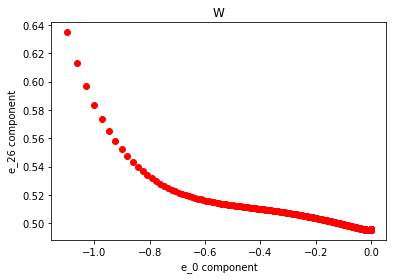

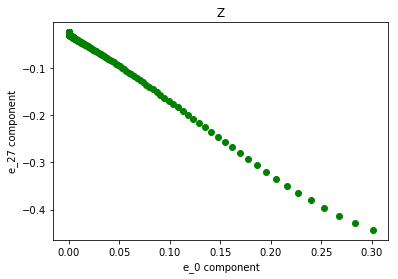

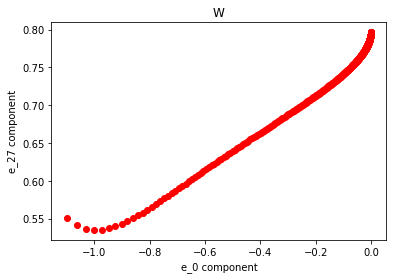

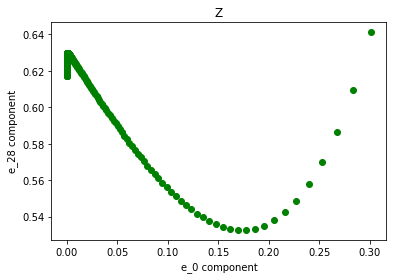

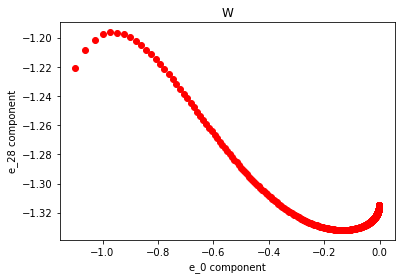

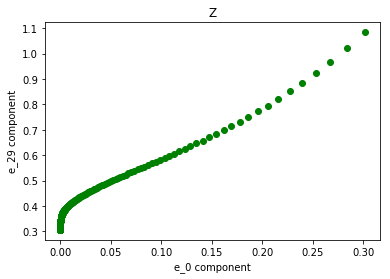

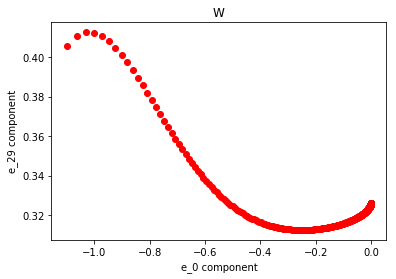

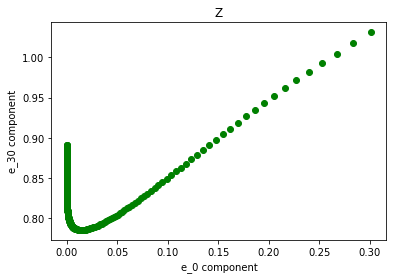

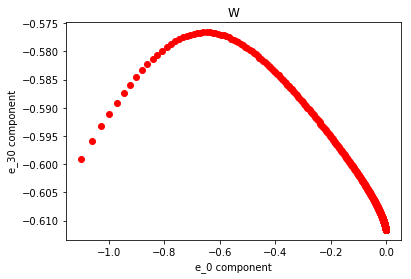

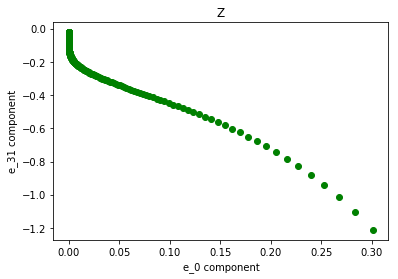

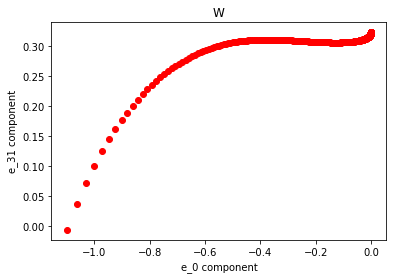

In [3]:
import numpy as np
import matplotlib.pyplot as plt


N = 100
M = 32
A = 0.001
E = 500


def hypercomplex_conjugate(a):
    if a.shape[-1] == 1:
        return a
    else:
        return np.concatenate([
            hypercomplex_conjugate(a[..., :(a.shape[-1] // 2)]),
            (-1 * a[..., (a.shape[-1] // 2):a.shape[-1]])
        ], axis=(len(a.shape) - 1))
    

def hypercomplex_multiply(a, b):
    if a.shape[-1] == 1:
        return a * b
    else:
        def cayley_dickson(p, q, r, s):
            return np.concatenate([
                (hypercomplex_multiply(
                    p,
                    r) -
                hypercomplex_multiply(
                    hypercomplex_conjugate(s),
                    q)),
                (hypercomplex_multiply(
                    s,
                    p) +
                hypercomplex_multiply(
                    q,
                    hypercomplex_conjugate(r))),
            ], axis=(len(a.shape) - 1))
        return cayley_dickson(
            a[..., :(a.shape[-1] // 2)],
            a[..., (a.shape[-1] // 2):],
            b[..., :(a.shape[-1] // 2)],
            b[..., (a.shape[-1] // 2):])
    

def hypercomplex_coefficient_gradient(a):
    h_t = np.zeros((a.shape[-1], a.shape[-1]))
    np.fill_diagonal(h_t, 1)
    h_t = h_t.reshape((1, a.shape[-1], a.shape[-1]))
    return h_t
    

z = np.random.normal(0, 1, (N, 1, M))
w = np.random.normal(0, 1, (N, 1, M))
h_t = hypercomplex_coefficient_gradient(z)

datapoints_z = []
datapoints_w = []
datapoints_loss = []


for _ in range(E):
    
    m = hypercomplex_multiply(z, w)
    m_c = hypercomplex_conjugate(m)
    loss = np.sum(hypercomplex_multiply(m, m_c)[:, :, 0])
    
    dz = hypercomplex_multiply(h_t, w)
    dz_c = hypercomplex_conjugate(dz)
    
    dw = hypercomplex_multiply(z, h_t)
    dw_c = hypercomplex_conjugate(dw)
    
    dm_dz = hypercomplex_multiply(dz, m_c) + hypercomplex_multiply(m, dz_c)
    dm_dz = dm_dz[:, :, 0].reshape((N, 1, M)) # Take the real component
    
    dm_dw = hypercomplex_multiply(dw, m_c) + hypercomplex_multiply(m, dw_c)
    dm_dw = dm_dw[:, :, 0].reshape((N, 1, M)) # Take the real component
    
    z -= A * dm_dz
    w -= A * dm_dw
    
    datapoints_z += [[z[0, 0, i] for i in range(M)]]
    datapoints_w += [[w[0, 0, i]for i in range(M)]]
    datapoints_loss += [loss]
    

print("Final Loss:", datapoints_loss[-1])
    
    
datapoints_z = np.array(datapoints_z)
datapoints_w = np.array(datapoints_w)
datapoints_loss = np.array(datapoints_loss)


plt.plot(datapoints_loss, "bo")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Gradient Descent")
plt.yscale("log")
plt.show()

for i in range(1, M):
    
    plt.plot(datapoints_z[:, 0], datapoints_z[:, i], "go")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("Z")
    plt.show()
    
    plt.plot(datapoints_w[:, 0], datapoints_w[:, i], "ro")
    plt.xlabel("e_0 component")
    plt.ylabel("e_%d component" % i)
    plt.title("W")
    plt.show()
